In [9]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Declare the variables for the region of interest

In [2]:
TOP = 100
BOTTOM = 300
RIGHT = 150
LEFT = 350

In [3]:
ROOT = os.getcwd()
ROOT

'c:\\Users\\dell-2019\\Desktop\\Sign Language Detection'

Testing the image contouring
[Code reference](https://stackoverflow.com/a/65794671/13280114)

In [6]:
def segment_hand_simple(img):
    # define the upper and lower boundaries of the HSV pixel intensities 
    # to be considered 'skin'
    
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype="uint8") 
    upper = np.array([20, 255, 255], dtype="uint8")
    skinMask= cv.inRange(hsvim, lower, upper)

    # blur the mask to help remove noise
    skinMask= cv.blur(skinMask, (2, 2))

    # get threshold image
    ret, thresh = cv.threshold(skinMask, 100, 255, cv.THRESH_BINARY)
    return thresh

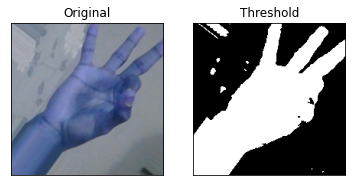

In [10]:
img_path = "images/train/f/sampled-0-1.png"
img = cv.imread(img_path)

thresh = segment_hand_simple(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(thresh)
ax[0].set_title("Original")
ax[1].set_title("Threshold")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.imshow(thresh, cmap='gray')

The ``generate_images()`` function is used to make augmented copies of the captured frame. This populates the dataset with a broad range of images to learn from.

In [8]:
# generates transformed images for more data
def generate_images(img, prefix='sampled'):
    # creates a data generator object that transforms images
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest')
    try:
        # pick an image to transform
        img = image.img_to_array(img)  # convert image to numpy array
        img = img.reshape((1,) + img.shape)  # reshape image
        i = 0
        # this loops runs forever until we break, saving images to current directory with specified prefix
        for batch in datagen.flow(img, save_prefix=prefix, save_format='png'):
            # plt.figure(i)
            # plot = plt.imshow(image.img_to_array(batch[0]))
            cv.imwrite(f'{prefix}-{i}.png', image.img_to_array(batch[0]))
            i += 1
            if i > 4:  # 4 images
                break
        plt.show()
    except Exception as e:
        print(f"[ERROR]  {e}")

Example of how the images are generated
create a subplot of all the generated images

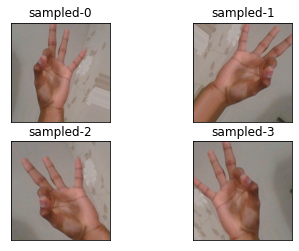

In [12]:
# os.chdir(ROOT)


fig, ax = plt.subplots(2, 2)
images = [image.load_img(f'images/train/f/sampled-0-{i}.png') for i in range(4)]
for i, img in enumerate(images):
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_title(f'sampled-{i}')

In [13]:
def chdir(path):
    if os.path.exists(f'images/{path}'):
        print('Directory changed to images')
    else:
        print('Directory not found')
        os.mkdir(f'images/{path}')
    os.chdir(f'images/{path}')

Here we begin collecting the images using OpenCV.<br>
Using the functions created above, we augument and segment the collected images.

In [39]:
# the letter of the hand
index = 'z'

# change directory to the folder where the images are
if os.getcwd() == ROOT:
    chdir(f"train/{index}")
else: 
    os.chdir(ROOT)
    chdir(f"train/{index}")

cam = cv.VideoCapture(0)
img_counter = 0

while True:
    ret, frame = cam.read()
    # filpping the frame to prevent inverted image of captured frame
    frame = cv.flip(frame, 1)
    
    if not ret:
        print("Please check if the camera is connected properly or is being used by another program")
        break

    
    # Drawing ROI on frame copy
    cv.imshow("Frame", frame)

    frame_copy = frame.copy()
    roi = frame[TOP:BOTTOM, RIGHT:LEFT] # get the region that we want to segment

    k = cv.waitKey(1)
    if k%256 == 27:
        break
    elif k%256 == 32: # SPACE pressed
        hand = roi#segment_hand_simple(roi)
        img_name = "{}.png".format(img_counter)
        path = os.getcwd() # get current working directory

        # save the image
        cv.imwrite(os.path.join(path , img_name), hand)

        # generate more images for the dataset
        generate_images(hand, f"sampled-{img_counter}")

        # increment the image counter
        img_counter += 1
        if img_counter == 6:
            break

    # Display the frame with segmented hand
    cv.rectangle(frame_copy, (LEFT, TOP), (RIGHT, BOTTOM), (255,128,0), 3)

    cv.imshow("Hand Region", roi)

cam.release()
cv.destroyAllWindows()
# change directory to the root directory
os.chdir(ROOT)

Directory not found


## Begin the data preparation
1. Load the images using Keras ImageDataGenerator. ImageDataGenerator is a high-level class that allows to yield data from multiple sources (from np arrays, from directories...) and that includes utility functions to perform image augmentation et cetera.
<br>
2. Create a normalization layer to standardize the data
<br>
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Therefore we standardize values to be in the [0, 1] range by using `rescale=(1./255)`

[Code Reference](https://www.tensorflow.org/tutorials/images/classification)

In [14]:
train_path = os.path.join(ROOT, "images/train")
test_path = os.path.join(ROOT, "images/test")

params = {
    'preprocessing_function': tf.keras.applications.vgg16.preprocess_input,
    'shear_range':0.2,
    'zoom_range':0.2,
    'horizontal_flip':False,
    'rescale':1./255,
}

train_batches = ImageDataGenerator(**params)

train_data = train_batches.flow_from_directory(
    directory=train_path, 
    target_size=(64,64), 
    class_mode='categorical', 
    batch_size=16,
    shuffle=True
)

Found 989 images belonging to 26 classes.


In [15]:
image_batch, labels_batch = next(train_data)
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]` and not `[0,255]`.
print(np.min(first_image), np.max(first_image))

-0.3521771 0.30847675


In [16]:
CLASSES = {v: k for k, v in train_data.class_indices.items()}
train_data.image_shape, CLASSES

((64, 64, 3),
 {0: 'a',
  1: 'b',
  2: 'c',
  3: 'd',
  4: 'e',
  5: 'f',
  6: 'g',
  7: 'h',
  8: 'i',
  9: 'j',
  10: 'k',
  11: 'l',
  12: 'm',
  13: 'n',
  14: 'o',
  15: 'p',
  16: 'q',
  17: 'r',
  18: 's',
  19: 't',
  20: 'u',
  21: 'v',
  22: 'w',
  23: 'x',
  24: 'y',
  25: 'z'})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

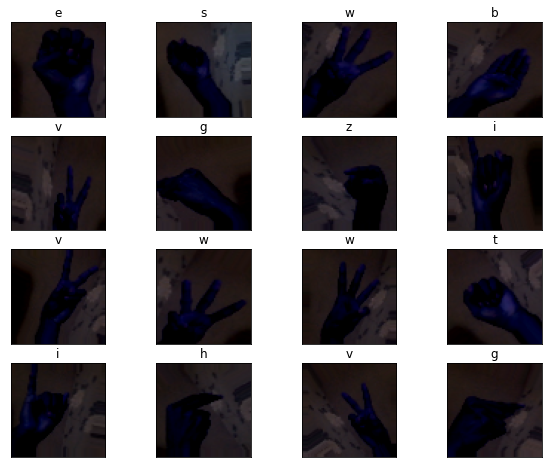

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the images
fig, ax = plt.subplots(4, 4, figsize=(10, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(image_batch[i])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_title(CLASSES[np.argmax(labels_batch[i])])
plt.show()
plt.tight_layout()

The images here are of bad quality (really dark and distorted) because the images were standardized when loading.
Meaning, the RGB values changed from `[0,255] -> [0,1]`, hence the lack of quality.

# Building the Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

In [29]:
INPUT_SHAPE = (64, 64, 3)
OUTPUT_SHAPE = train_data.num_classes

In [59]:
layers = [
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(OUTPUT_SHAPE, activation="softmax")
]

params = {
    'loss': 'categorical_crossentropy',
    'optimizer': Adam(learning_rate=0.001),
    'metrics': ['accuracy']
}

In [60]:
model = Sequential(layers)

# compile the model with params
model.compile(**params)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 128)       

NOTE: You need to install [Graphviz](https://graphviz.org/download/) and `pydot` for the following cell to run

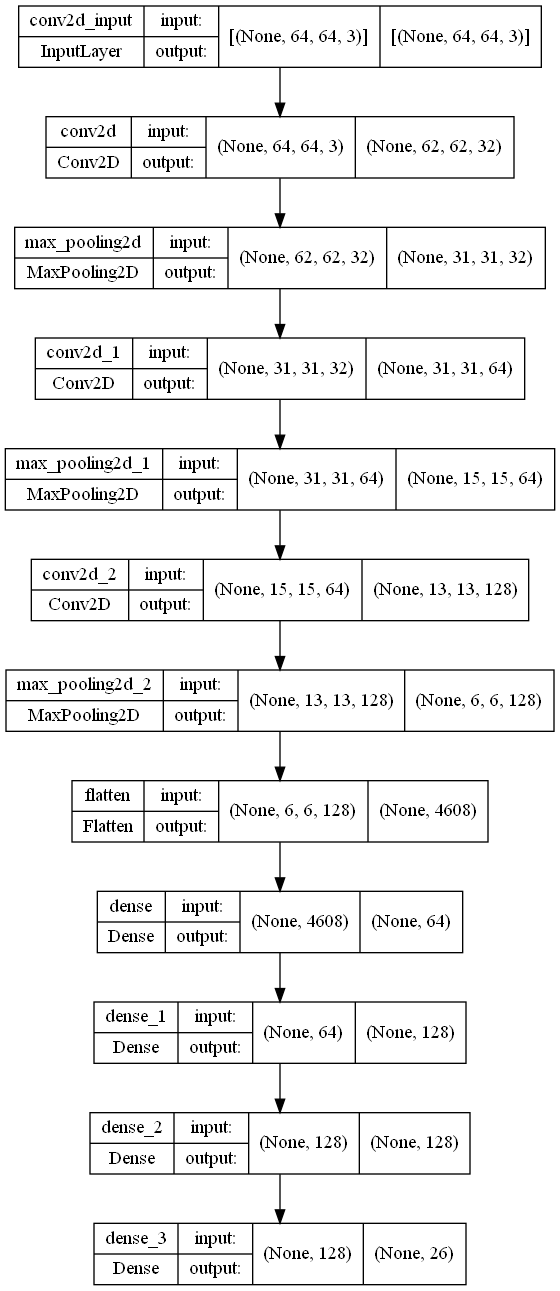

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Early stopping and reduce learning rate because running at 50 epochs takes a long time and the model's accuracy also fluctuates alot.

In [61]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [33]:
history = model.fit(train_data, epochs=50, callbacks=[reduce_lr, early_stop])

Epoch 1/50
62/62 [==============================] - 59s 895ms/step - loss: 3.2061 - accuracy: 0.0637
Epoch 2/50
62/62 [==============================] - 9s 148ms/step - loss: 2.7600 - accuracy: 0.1567
Epoch 3/50
62/62 [==============================] - 9s 144ms/step - loss: 2.2754 - accuracy: 0.2487
Epoch 4/50
62/62 [==============================] - 9s 142ms/step - loss: 1.9092 - accuracy: 0.3842
Epoch 5/50
62/62 [==============================] - 9s 141ms/step - loss: 1.5311 - accuracy: 0.4995
Epoch 6/50
62/62 [==============================] - 9s 151ms/step - loss: 1.2353 - accuracy: 0.5905
Epoch 7/50
62/62 [==============================] - 9s 142ms/step - loss: 0.9229 - accuracy: 0.6987
Epoch 8/50
62/62 [==============================] - 9s 144ms/step - loss: 0.8837 - accuracy: 0.7118
Epoch 9/50
62/62 [==============================] - 9s 146ms/step - loss: 0.5505 - accuracy: 0.8210
Epoch 10/50
62/62 [==============================] - 9s 141ms/step - loss: 0.5488 - accuracy: 0.804

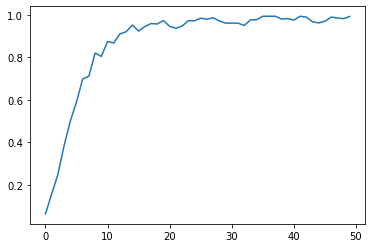

In [38]:
# plot the training loss and accuracy
plt.plot(history.history['accuracy'])

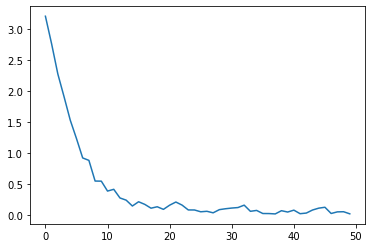

In [39]:
plt.plot(history.history['loss'])

In [ ]:
# # prepare the test data
# from random import sample

# os.chdir(ROOT)

# for letter in CLASSES.keys():
#     path = f"images/test/{letter}/"
#     print(path)
#     files = os.listdir(path)
#     for file in sample(files,8):
#         os.remove(path+file)

In [76]:
# load the test data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_data = test_batches.flow_from_directory(
    directory=test_path,
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=62,
    shuffle=True
)

imgs, labels = next(test_data)

Found 495 images belonging to 26 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'q')

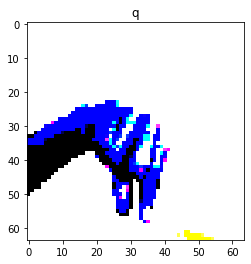

In [112]:
plt.imshow(imgs[0], cmap='gray')
plt.title(CLASSES[np.argmax(labels[0])])

# Model Evaluation

In [62]:
# load saved model and evaluate
from keras.models import load_model
saved_model = load_model('./models/vgg16-90.h5')

In [69]:
def eval_model(model, imgs, labels):
    loss, acc = model.evaluate(imgs, labels, verbose=0)
    print(f"Test loss: {loss:.2f}")
    print(f"Test accuracy: {acc*100}%")

In [143]:
eval_model(saved_model, imgs, labels)
eval_model(model, imgs, labels)

Test loss: 73.84
Test accuracy: 90.32257795333862%
Test loss: 5.38
Test accuracy: 4.838709533214569%


## Confusion matrix

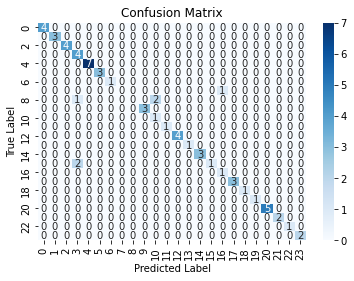

Precision: 85.02%
Recall: 88.89%
Log loss: 2.88


c:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss
import seaborn as sns

y_pred = saved_model.predict(imgs)
cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(y_pred, axis=1))

# plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# fig, ax = plt.subplots()
# ax.matshow(cm)
# plt.title('Confusion matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

# calculate precision, recall, and log loss
precision = precision_score(np.argmax(labels, axis=1), np.argmax(y_pred, axis=1), average='macro')
recall = recall_score(np.argmax(labels, axis=1), np.argmax(y_pred, axis=1), average='macro')
loss = log_loss(labels, y_pred)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Log loss: {loss:.2f}")

## AUC ROC curve

In [122]:
from sklearn.metrics import roc_curve, auc

# calculate the roc curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(OUTPUT_SHAPE):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# print the AUC for each class
for i in range(OUTPUT_SHAPE):
    print(f"Class {CLASSES[i]}: {roc_auc[i]:.2f}")

Class a: 1.00
Class b: 1.00
Class c: 1.00
Class d: 0.97
Class e: 1.00
Class f: 1.00
Class g: 1.00
Class h: 1.00
Class i: 0.50
Class j: nan
Class k: 1.00
Class l: 0.98
Class m: 1.00
Class n: nan
Class o: 1.00
Class p: 1.00
Class q: 1.00
Class r: 0.67
Class s: 1.00
Class t: 1.00
Class u: 1.00
Class v: 1.00
Class w: 1.00
Class x: 1.00
Class y: 1.00
Class z: 1.00


c:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


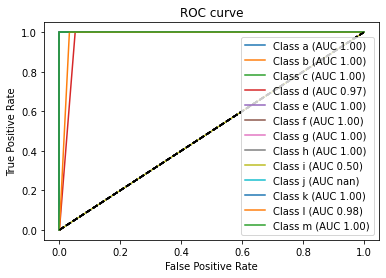

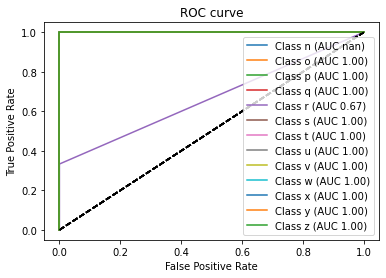

In [123]:
# plot the roc curve for each class
fig, ax = plt.subplots()
for i in range(13):
    ax.plot(fpr[i], tpr[i], label=f'Class {CLASSES[i]} (AUC {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(13, OUTPUT_SHAPE, 1):
    ax.plot(fpr[i], tpr[i], label=f'Class {CLASSES[i]} (AUC {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend()
plt.show()

# Making predictions

In [127]:
try:
    predictions = saved_model.predict(imgs)
    predictions
except Exception as e:
    print(e.__context__)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: q; Actual: q


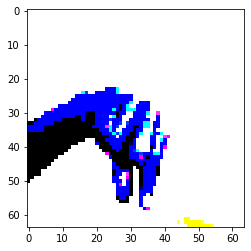

In [129]:
# loop through the test data and print the prediction and the actual label
plt.imshow(imgs[0])
print(f'Prediction: {CLASSES[predictions[0].argmax()]}; Actual: {CLASSES[labels.argmax()]}')

In [130]:
def make_predictions(model, test_batches):
    imgs, labels = next(test_batches)
    predictions = model.predict(imgs)
    return predictions, labels, imgs[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: d; Actual: d


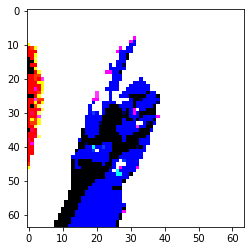

In [134]:
pred, true, img = make_predictions(saved_model, test_data)

plt.imshow(img)
print(f'Prediction: {CLASSES[pred[0].argmax()]}; Actual: {CLASSES[true.argmax()]}')

Save the model

In [157]:
model.save('vgg16-90.h5')

Testing the predictions in an easy way, by printing the true labels and predicted labels

In [142]:
# check the accuracy of the model
from termcolor import colored

loss = 0
prediction = saved_model.predict(imgs)
for i in range(20):
    # print(CLASSES[np.argmax(prediction)], "->", CLASSES[np.argmax(y_test[i])])
    predicted_class, actual_class = CLASSES[np.argmax(prediction[i])], CLASSES[np.argmax(labels[i])]

    # checks for the classes and sets color's depending on that
    color = 'green' if predicted_class == actual_class else 'red'
    if color == 'red': loss += 1
    print(colored(f'[{i}] Predicted : {predicted_class : <2}|  Expected : {actual_class}', color))

# perc = round(100/(batch/(batch-loss)), 3)
# print(f"Accuracy {perc}%\nLoss : {100-perc}%")

[0] Predicted : q |  Expected : q
[1] Predicted : w |  Expected : w
[2] Predicted : m |  Expected : m
[3] Predicted : d |  Expected : r
[4] Predicted : c |  Expected : c
[5] Predicted : e |  Expected : e
[6] Predicted : e |  Expected : e
[7] Predicted : k |  Expected : k
[8] Predicted : x |  Expected : x
[9] Predicted : d |  Expected : d
[10] Predicted : p |  Expected : p
[11] Predicted : w |  Expected : w
[12] Predicted : c |  Expected : c
[13] Predicted : w |  Expected : w
[14] Predicted : y |  Expected : y
[15] Predicted : b |  Expected : b
[16] Predicted : d |  Expected : d
[17] Predicted : a |  Expected : a
[18] Predicted : k |  Expected : k
[19] Predicted : d |  Expected : d
